In [1]:
!nvidia-smi

Thu Jun 25 19:47:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 22%   32C    P8     3W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 23%   33C    P8     1W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
import pathlib

import pandas as pd
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [3]:
batch_size = 32
epochs = 5
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [4]:
train_dir = 'train/train/'

In [5]:
data_dir = pathlib.Path(train_dir)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES.sort()
CLASS_NAMES

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41'], dtype='<U2')

In [6]:
def import_data(data_dir):
    list_ds = tf.data.Dataset.list_files(data_dir + "*/*")

    def process_path(file_path):
        label = tf.strings.split(file_path, os.path.sep)[-2] == CLASS_NAMES

        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

        return img, label

    return list_ds.map(process_path)

train_ds = import_data(train_dir)

In [7]:
train_ds = train_ds.shuffle(1000)

validation = train_ds.take(10000)
train = train_ds.skip(10000)

Image shape:  (224, 224, 3)
Label:  [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


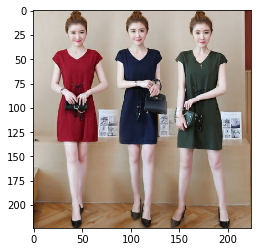

In [9]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(image.numpy())

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train.batch(batch_size).prefetch(AUTOTUNE)

In [11]:
base_model = tf.keras.applications.ResNet152V2(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(42)

In [12]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs,
)

Epoch 1/5


KeyboardInterrupt: 